<a href="https://colab.research.google.com/github/BilalAsifB/Learning-PyTorch/blob/main/notebooks/01_pytorch_workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn

print(torch.__version__)

2.9.0+cpu


In [62]:
RANDOM_SEED = 42

#### Preparing and loading data

In [63]:
# creating known parameters
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.02

In [64]:
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

In [65]:
len(X), len(y)

(50, 50)

In [66]:
# Splitting data into train and test sets
train_split = int(0.8 * len(X))

X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

In [67]:
len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [68]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
    """
    Plots training data, test data and compares predictions
    """
    plt.figure(figsize=(10, 7))

    # plot train data
    plt.scatter(train_data, train_labels, c='b', s=10,
                label='Train data')

    # plot test data
    plt.scatter(test_data, test_labels, c='r', s=10,
                label='Test data')

    # plot predictions if exist
    if predictions is not None:
        plt.scatter(test_data, predictions, c='y', s=10,
                    label='Predictions')

    # show legend
    plt.legend(prop={'size': 14})

    plt.show()

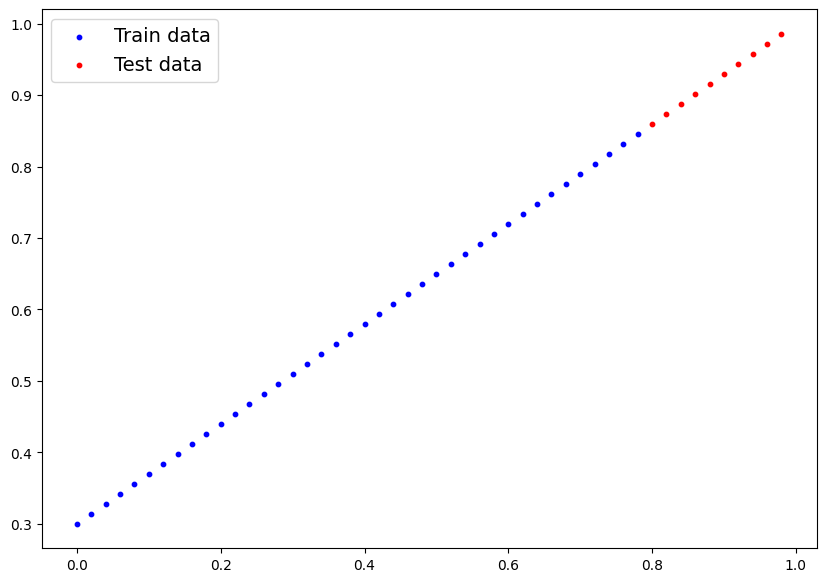

In [69]:
plot_predictions()

### Building a model

##### PyTorch model building essentials:
- **torch.nn** - contains all the building blocks for the computational graphs
- **torch.nn.Parameter** - paramteres the model should learn (mostly set by the PyTorch layer for us)
- **torch.nn.Module** - the base class for all Neural Network modules
- **torch.optim** - optimizers
- **def forward()** - all nn.Module subclasses require forward() method overwritten
- **torch.utils.data.Dataset** - represesnts a map between key and sample pairs of data
- **torch.utils.data.DataLoader** -  python iterator over torch Dataset

*PyTorch cheatsheet:* https://pytorch-cn.com/tutorials/beginner/ptcheat.html

In [70]:
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1,
                                                requires_grad=True,
                                                dtype=torch.float))
        self.bias = nn.Parameter(torch.randn(1,
                                             requires_grad=True,
                                             dtype=torch.float))

    # Forward pass
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.weights * x + self.bias

In [71]:
torch.manual_seed(RANDOM_SEED)

model = LinearRegressionModel()

In [72]:
list(model.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [73]:
model.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [74]:
with torch.inference_mode(): # inference_mode allows faster inference
    y_preds = model(X_test)

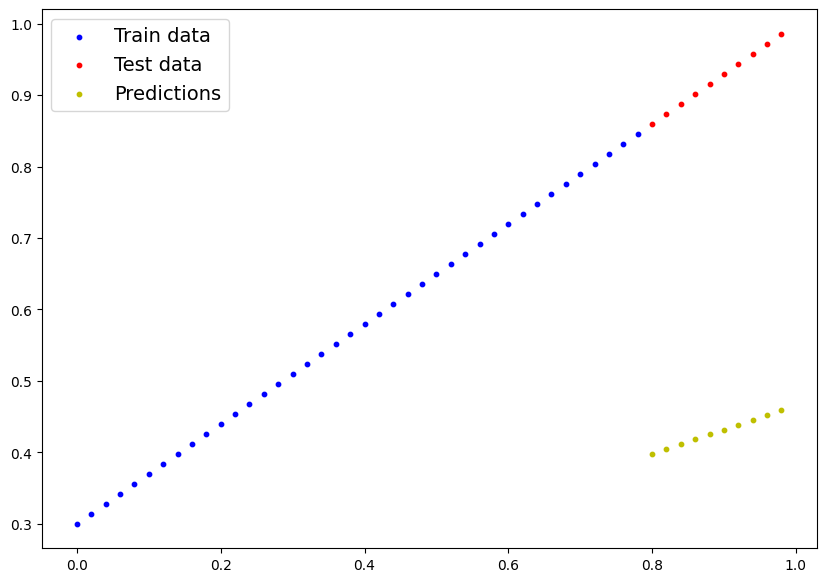

In [75]:
plot_predictions(predictions=y_preds)

### Model training and testing

In [76]:
 loss_fn = nn.L1Loss()
 optimizer = torch.optim.SGD(params=model.parameters(),
                             lr=0.01)

In [77]:
torch.manual_seed(RANDOM_SEED)
epochs = 100

epoch_count = []
train_loss_values = []
test_loss_values = []

for epoch in range(epochs + 1):
    model.train() # set parameters that need gradient tracking
    # 1. Forward pass
    y_pred = model(X_train)
    # 2. Loss calculation
    loss = loss_fn(y_pred, y_train)
    # 3. Optimizer zero grad
    optimizer.zero_grad() # zero out gradient accumulated in the previous epoch
    # 4. Backpropagation
    loss.backward()
    # 5. Step the optimizer (gradient descent)
    optimizer.step()

    model.eval() # turnoff gradient tracking
    with torch.inference_mode():
        test_preds = model(X_test)
        test_loss = loss_fn(test_preds, y_test)


    if epoch % 10 == 0:
        epoch_count.append(epoch)
        train_loss_values.append(loss)
        test_loss_values.append(test_loss)
        print(f'Epoch: {epoch} | Training Loss: {loss} | Testing Loss: {test_loss}')
        print(model.state_dict())

Epoch: 0 | Training Loss: 0.31288138031959534 | Testing Loss: 0.48106518387794495
OrderedDict({'weights': tensor([0.3406]), 'bias': tensor([0.1388])})
Epoch: 10 | Training Loss: 0.1976713240146637 | Testing Loss: 0.3463551998138428
OrderedDict({'weights': tensor([0.3796]), 'bias': tensor([0.2388])})
Epoch: 20 | Training Loss: 0.08908725529909134 | Testing Loss: 0.21729660034179688
OrderedDict({'weights': tensor([0.4184]), 'bias': tensor([0.3333])})
Epoch: 30 | Training Loss: 0.053148526698350906 | Testing Loss: 0.14464017748832703
OrderedDict({'weights': tensor([0.4512]), 'bias': tensor([0.3768])})
Epoch: 40 | Training Loss: 0.04543796554207802 | Testing Loss: 0.11360953003168106
OrderedDict({'weights': tensor([0.4748]), 'bias': tensor([0.3868])})
Epoch: 50 | Training Loss: 0.04167863354086876 | Testing Loss: 0.09919948130846024
OrderedDict({'weights': tensor([0.4938]), 'bias': tensor([0.3843])})
Epoch: 60 | Training Loss: 0.03818932920694351 | Testing Loss: 0.08886633068323135
Ordered

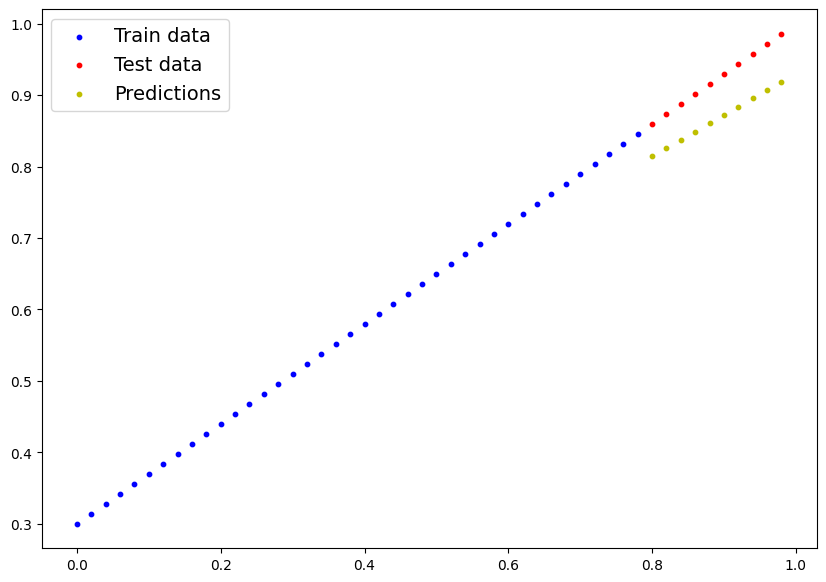

In [78]:
with torch.inference_mode():
    y_preds = model(X_test)

plot_predictions(predictions=y_preds)

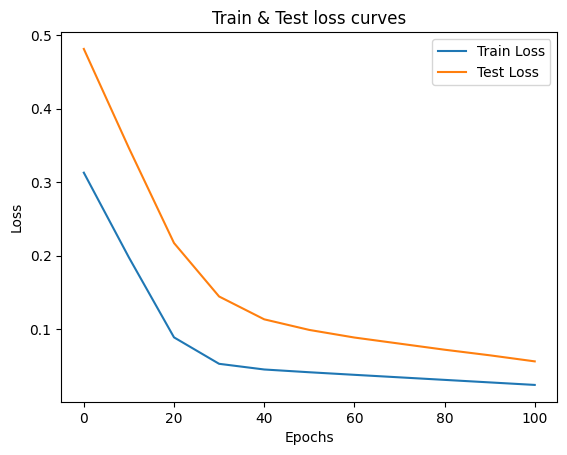

In [81]:
plt.plot(epoch_count, [loss.detach().numpy() for loss in train_loss_values], label='Train Loss')
plt.plot(epoch_count, [loss.detach().numpy() for loss in test_loss_values], label='Test Loss')
plt.title('Train & Test loss curves')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

### Saving the model

In [82]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True)
MODEL_NAME = "01_pytorch_workflow_model.pth"
MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME

MODEL_SAVE_PATH

PosixPath('models/01_pytorch_workflow_model.pth')

In [83]:
torch.save(obj=model.state_dict(),
           f=MODEL_SAVE_PATH)

In [84]:
loaded_model = LinearRegressionModel()

loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [85]:
loaded_model.state_dict()

OrderedDict([('weights', tensor([0.5800])), ('bias', tensor([0.3503]))])

### Putting it all together

In [143]:
import torch
from torch import nn
import matplotlib.pyplot as plt

print(torch.__version__)

2.9.0+cpu


In [144]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [145]:
weights = 0.64
bias = 0.17

start = 0
end = 1
step = 0.005

X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weights * X + bias

In [146]:
X.to(DEVICE)
y.to(DEVICE)

tensor([[0.1700],
        [0.1732],
        [0.1764],
        [0.1796],
        [0.1828],
        [0.1860],
        [0.1892],
        [0.1924],
        [0.1956],
        [0.1988],
        [0.2020],
        [0.2052],
        [0.2084],
        [0.2116],
        [0.2148],
        [0.2180],
        [0.2212],
        [0.2244],
        [0.2276],
        [0.2308],
        [0.2340],
        [0.2372],
        [0.2404],
        [0.2436],
        [0.2468],
        [0.2500],
        [0.2532],
        [0.2564],
        [0.2596],
        [0.2628],
        [0.2660],
        [0.2692],
        [0.2724],
        [0.2756],
        [0.2788],
        [0.2820],
        [0.2852],
        [0.2884],
        [0.2916],
        [0.2948],
        [0.2980],
        [0.3012],
        [0.3044],
        [0.3076],
        [0.3108],
        [0.3140],
        [0.3172],
        [0.3204],
        [0.3236],
        [0.3268],
        [0.3300],
        [0.3332],
        [0.3364],
        [0.3396],
        [0.3428],
        [0

In [147]:
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(160, 160, 40, 40)

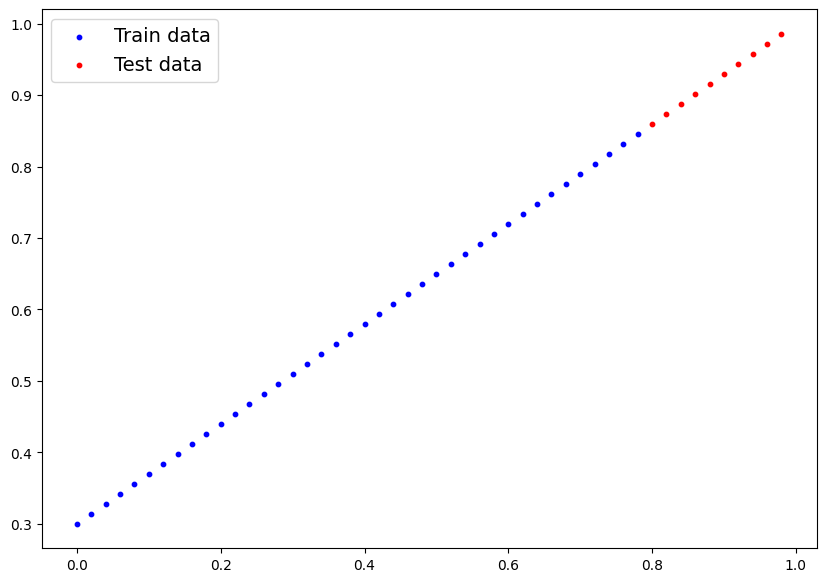

In [148]:
plot_predictions()

In [149]:
class LinearRegressionModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer = nn.Linear(in_features=X_train.shape[1],
                                      out_features=X_test.shape[1])

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)

In [150]:
torch.manual_seed(RANDOM_SEED)

model_v2 = LinearRegressionModelV2()

In [151]:
model_v2.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
             ('linear_layer.bias', tensor([0.8300]))])

In [152]:
model_v2.to(DEVICE)
next(model_v2.parameters()).device

device(type='cpu')

In [153]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_v2.parameters(),
                            lr=0.01)

In [154]:
torch.manual_seed(RANDOM_SEED)

epochs = 200
epoch_count = []
training_loss = []
testing_loss = []

for epoch in range(epochs + 1):
    model_v2.train()
    train_preds = model_v2(X_train)
    train_loss = loss_fn(train_preds, y_train)
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    model_v2.eval()
    with torch.inference_mode():
        test_preds = model_v2(X_test)
        test_loss = loss_fn(test_preds, y_test)

    if epoch % 10 == 0:
        epoch_count.append(epoch)
        training_loss.append(train_loss)
        testing_loss.append(test_loss)
        print(f'Epoch: {epoch} | Training loss: {train_loss:.5} | Tesing loss: {test_loss:.5}')

Epoch: 0 | Training loss: 0.70951 | Tesing loss: 0.75821
Epoch: 10 | Training loss: 0.59371 | Tesing loss: 0.62254
Epoch: 20 | Training loss: 0.47791 | Tesing loss: 0.48686
Epoch: 30 | Training loss: 0.36211 | Tesing loss: 0.35119
Epoch: 40 | Training loss: 0.24631 | Tesing loss: 0.21551
Epoch: 50 | Training loss: 0.13051 | Tesing loss: 0.079837
Epoch: 60 | Training loss: 0.027012 | Tesing loss: 0.039434
Epoch: 70 | Training loss: 0.02019 | Tesing loss: 0.045912
Epoch: 80 | Training loss: 0.016765 | Tesing loss: 0.038412
Epoch: 90 | Training loss: 0.013345 | Tesing loss: 0.030566
Epoch: 100 | Training loss: 0.0099248 | Tesing loss: 0.022547
Epoch: 110 | Training loss: 0.0065049 | Tesing loss: 0.014356
Epoch: 120 | Training loss: 0.0030852 | Tesing loss: 0.0063374
Epoch: 130 | Training loss: 0.002949 | Tesing loss: 0.0075276
Epoch: 140 | Training loss: 0.002949 | Tesing loss: 0.0075276
Epoch: 150 | Training loss: 0.002949 | Tesing loss: 0.0075276
Epoch: 160 | Training loss: 0.002949 | T

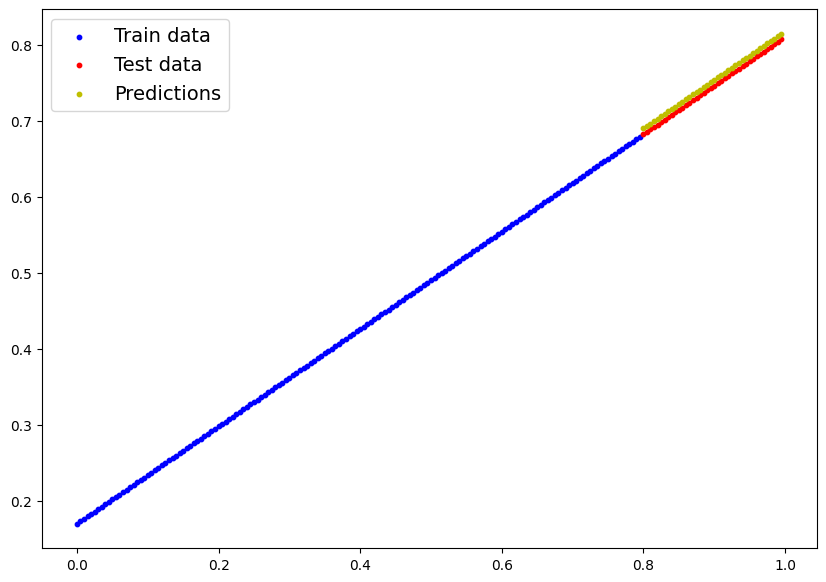

In [156]:
model_v2.eval()
with torch.inference_mode():
    preds = model_v2(X_test)

plot_predictions(train_data=X_train,
                 train_labels=y_train,
                 test_data=X_test,
                 test_labels=y_test,
                 predictions=preds)

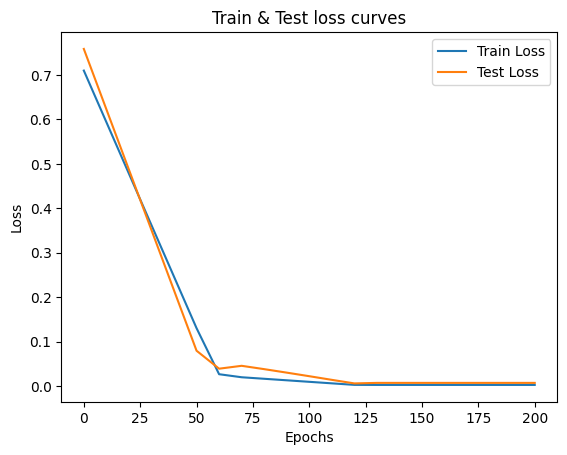

In [165]:
plt.plot(epoch_count, [loss.detach().numpy() for loss in training_loss], label='Train Loss')
plt.plot(epoch_count, [loss.detach().numpy() for loss in testing_loss], label='Test Loss')
plt.title('Train & Test loss curves')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [157]:
MODEL_PATH = Path('models')
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True)
MODEL_NAME = '01_pytorch_workflow_model_v2.pth'
MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME

MODEL_SAVE_PATH

PosixPath('models/01_pytorch_workflow_model_v2.pth')

In [159]:
torch.save(obj=model_v2.state_dict(),
           f=MODEL_SAVE_PATH)

In [161]:
loaded_model_v2 = LinearRegressionModelV2()

In [162]:
loaded_model_v2.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [163]:
loaded_model_v2.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6378]])),
             ('linear_layer.bias', tensor([0.1795]))])